# Modello Muni Toke Yoshida

I principali miglioramenti del modello MTY si concentrano su:

1. Piazzamento LO
2. Piazzamento cancellazioni (C)
3. Intensità di LO, MO C come funzioni dello spread



In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import scipy.stats
import sys
sys.path.append("../main/")
from double_t import EM
import MTY, ZI
    
plt.style.use('dark_background')

In [2]:
#load data
path = "../data/energia/order/new_best.csv"
data = ZI.load_LOB_data(path)

# 1) Piazzamento LO

Per modellare il piazzamento dei LO utilizzo la distribuzione empirica della distanza dei LO dal best price della stessa quota.

Inoltre mi aspetto che la forma della distribuzione cambi sostanzialmente al variare dello spread, ovvero quando lo spread è basso mi aspetto che la maggior parte degli ordini sia fatto all'interno del book, mentre quando lo spread è alto mi aspetto che la maggior parte di loro sia all'interno dello spread.

Per passare al simulatore una distribuzione che dipende dallo spread, utilizzo la funzione LO_placement_spread:

### Input

1. new_df: pd.DataFrame
    - Il dataframe dello stato del LOB "pulito"
2. tot: int
    - DSA
3. interval: int
    - L'intervallo di spread considerato ad ogni iterazione
4. range_distr: np.array of int
    - Array contenente i bin della distribuzione dello spread
5. show_fig: bool (default = False)
    - Se True crea plot per visualizzare la distribuzione
    

### Output
1. f_distr: object FamilyDistribution
    - Oggetto che mi ritorna una determinata distribuzione in base allo spread

Supponiamo che voglio la distribuzione empirica del piazzamento dei LO per 3 diversi valori di spread:

1. Spread [0, 70)
2. Spread [70, 140)
3. Spread [140 , $\inf$]

Il valore della variabile tot deve allora essere 3, mentre il valore della variabile interval deve essere uguale a 7.

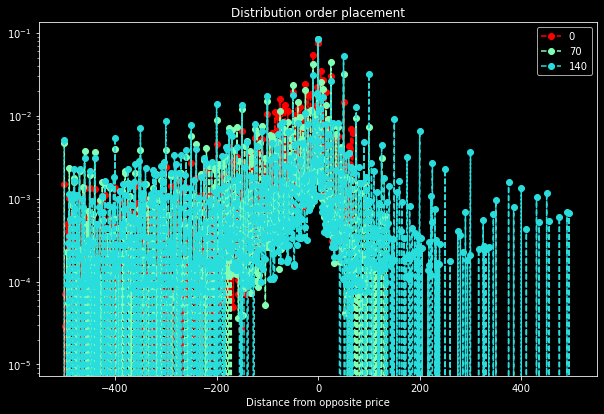

In [3]:
f_distr = MTY.LO_placement_spread(data, tot = 3, interval = 70, 
                              range_distr = np.arange(-500,500, 1), show_fig = True)

## 2) Piazzamento cancellazioni

Per il piazzamento delle cancellazioni ho usato il priority index (vedere articolo di Muni Toke e Yoshida).

La distribuzione del placement delle cancellazioni in funzione del priority index $\zeta$ può essere fittata come una power law troncata:

$\pi_C(\zeta: \alpha, \sigma) = \frac{\sigma (\alpha + 1)}{(1 + \sigma)^{(\alpha + 1)} - 1} (1+\sigma \zeta)^\alpha $

Per stimare i parametri $\alpha$ (esponente power law) $\sigma$ (parametro scaling), faccio massimizzazione della funzione di log likelihood.

Per fare questo utilizzo la funzione p_index_estimation:

### Input:
1. new_df: pd.DataFrame
    - Dataframe dati "puliti"
2. guess: tuple (default = (-1, 1))
    - Valori iniziali per $\alpha$ e $\sigma$ ($\alpha$ $\in$ $[0,1]$)

### Output
1. a: float
    - Valore del parametro $\alpha$
2. s: float
    - Valore del parametro $\sigma$
3. p_index: np.array
    - Array che contiene il priority index di ogni cancellazione. 

In [5]:
# Compute parameters tpl
alpha, sigma, p_index = MTY.p_index_estimation(data, guess  = (-2, 8))

Parameters estimated successfully: alpha = -0.593, sigma = 13.650


../main\MTY.py:157: RuntimeWarning: invalid value encountered in double_scalars
  ret = N * np.log(s * (a +1) / ((1+ s)**(a +1) - 1))


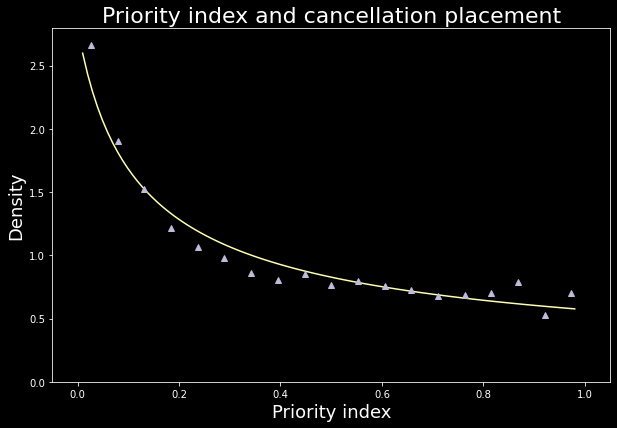

In [9]:
# plot the distribution
fig, ax = plt.subplots(1,1, figsize = (10,6.5))
n, n_bins, _ = plt.hist(p_index, density = True, bins = np.linspace(0,1,20), alpha = 0)
x = (n_bins[1:] + n_bins[:-1]) / 2
xx = np.linspace(0.01, 0.98,100)
plt.plot(xx, MTY.truncated_power_law(xx, alpha, sigma))
plt.plot(x, n, ls = "", marker = "^")
            
ax.set_title(f"Priority index and cancellation placement", fontsize = 22)
ax.set_xlabel("Priority index", fontsize = 18)
ax.set_ylabel("Density", fontsize = 18)
plt.show()
            

## Intensità degli ordini come funzione dello spread

In un articolo del 2016 Muni Toke e Yoshida hanno proposto un modello di LOB con intensità di LO, MO e cancellazioni che dipende dallo spread.

Chiamati $\lambda_{LO}$, $\lambda_{MO}$ e $\lambda_C$ i rate di arrivo dei LO, MO e cancellazioni, abbiamo che:

$$\lambda_{LO}(S) = \frac{N_{LO}(S)}{T(S)}$$

dove $N_{LO}(S)$ indica il numero totale di LO piazzati quando lo spread è uguale ad S e $T(S)$ indica il tempo totale in cui lo spread è uguale ad S (definizioni simili possono essere utilizzate per $\lambda_{MO}$ e $\lambda_C$).

Muni Toke e Yoshida hanno poi trovato che le intensità possono essere modellate come:

- $ \lambda_{LO}(t,S,\beta)= exp(\beta^L_0 + \beta^L_1 log(1 + S_t) + \beta^L_2 (log(1+S_t))^2)$
- $\lambda_{MO}(t,S, \beta)= exp(\beta^M_0 + \beta^M_1 log(1 + S_t) + \beta^M_2 (log(1+S_t))^2)$
- $\lambda_{C}(t, S,n_{tot}, \beta)= exp(\beta^C_0 + \beta^C_1 log(1 + S_t) + \beta^C_2 (log(1+S_t))^2 + log(1 + n_{tot}))$

con $n_{tot}$ uguale al numero totale di ordini nel book.

I valori dei parametri $\beta^L_0, \beta^L_1, \beta^L_2$ (stessa cosa per MO e C) possono essere ricavati tramite massimizzazione della log-likelihood:
$$log L = \int_0^T \lambda_{LO}(t,S,\beta) dN^{LO}_t - \int_0^T \lambda_{LO}(t,S,\beta) dt$$

Il problema di questo approccio però, è che sia nella definizione delle intensità, sia nella stima per i parametri abbiamo bisogno di informazioni sul tempo t che non sempre sono corrette per i dati energetici (esempio quando abbiamo un update lo devo modellare come una cancellazione + un LO, ma come assegno il tempo che passa dalla cancellazione al LO?).

Per questo motivo piuttosto che calcolare il rate assoluto di arrivo, calcolo il rate relativo, ovvero:

$$r_{LO} = \frac{\lambda_{LO}}{\lambda_{LO} + \lambda_{MO} + \lambda_{C}} = \frac{N_{LO}}{N_{LO} + N_{MO} + N_{C}} $$

(definizioni simili possono esser fatte per MO e cancellazioni).

Definiti:
- $\theta^{M}_i = \beta^M_i - \beta^L_i$, con  $i \in [0,1,2]$
- $\theta^{C}_i = \beta^C_i - \beta^L_i$, con  $i \in [0,1,2]$

vale che:

$$r_{LO} = \biggl[1 + exp(-\theta^{M}_0 -\theta^{M}_1 log(1+S) - \theta^{M}_2 (log(1 +S))^2) +  \\ 
exp(-\theta^{C}_0 -\theta^{C}_1 log(1+S) - \theta^{C}_2 (log(1 +S))^2 - log(1+n_{tot})) \biggr]^{-1}$$

$$r_{MO} = \biggl[1 + exp(\theta^{M}_0 +\theta^{M}_1 log(1+S) + \theta^{M}_2 (log(1 +S))^2) + \\ exp((\theta^M_0 - \theta^{C}_0)  +(\theta^M_1 - \theta^{C}_1) log(1+S) + (\theta^M_2 - \theta^{C}_2) (log(1 +S))^2 - log(1+n_{tot})) \biggr]^{-1}$$

$$r_{C} = \biggl[1 + exp(\theta^{C}_0 +\theta^{C}_1 log(1+S) + \theta^{C}_2 (log(1 +S))^2 +log(1+n_{tot})) + \\ exp((\theta^C_0 - \theta^{M}_0)  +(\theta^C_1 - \theta^{M}_1) log(1+S) + (\theta^C_2 - \theta^{M}_2) (log(1 +S))^2 + log(1 + n_{tot})) \biggr]^{-1}$$

I parametri $\theta^M_i$ e $\theta^C_i$ possono essere stimati tramite massimizzazione della log-likelihood:

$$ logL = \int r_{LO}dN^{LO}_t + \int r_{MO}dN^{MO}_t + \int r_{C}dN^{C}_t $$

A prima vista questo approccio può sembrare molto più complicato di quello originale proposto da MTY nel 2016, ma 






In [4]:
data["NumOrders"] = (data["TotVolume"] / data["Volume"].mean()).round()

l,m,c = MTY.ratio_orders(data, "Spread")

     fun: 124961.78371027592
     jac: array([-0.00390625, -0.01953125, -0.05566406,  0.02148438,  0.08007812,
        0.3203125 ])
 message: 'Optimization terminated successfully'
    nfev: 157
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([-2.41719694e-01, -4.25121588e-01, -2.93980765e-02, -2.66252046e+00,
       -3.50508512e-02,  1.48810900e-03])


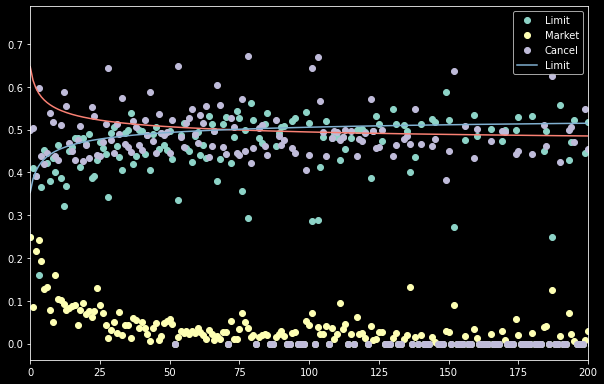

In [5]:
fig, ax = plt.subplots(1,1, figsize = (10,6.5))
plt.plot(l, label = "Limit", marker = "o", ls= "")
plt.plot(m, label = "Market", marker = "o", ls= "")
plt.plot(c, label = "Cancel", marker = "o", ls= "")
plt.xlim(0,200)

pp = MTY.compute_ratio(data, "Spread", (-0.08,-1,-0.1,0.3,-0.1,0.004))
xx = np.linspace(0,200,200)
ff2 = Ratio(*pp,0, 1)
ff3 = Ratio(pp[3], pp[4], pp[5],pp[0], pp[1], pp[2], 1 , 0)
ff1 = Ratio_l(*pp)
NN = 15
plt.plot(xx,ff2.find_rate(xx,NN))
plt.plot(xx,ff3.find_rate(xx,NN))
plt.plot(xx,ff1.find_rate(xx, NN))
plt.legend()

In [6]:
data["NumOrders"] = (data["TotVolume"] / data["Volume"].mean()).round()

../main\pars_mf_model.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx_bid = new_df.loc[idx_sp[:-1]][(new_df["Sign"] == 1) & \
../main\pars_mf_model.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx_ask = new_df.loc[idx_sp[:-1]][(new_df["Sign"] == -1) & \
../main\pars_mf_model.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx_bid = new_df.loc[idx_sp[:-1]][(new_df["Sign"] == 1) & \
../main\pars_mf_model.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx_ask = new_df.loc[idx_sp[:-1]][(new_df["Sign"] == -1) & \
../main\pars_mf_model.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx_bid = new_df.loc[idx_sp[:-1]][(new_df["Sign"] == 1) & \
../main\pars_mf_model.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idx_ask = new_df.loc[idx_sp[:-1]][(new_df["Sign"] == -1)

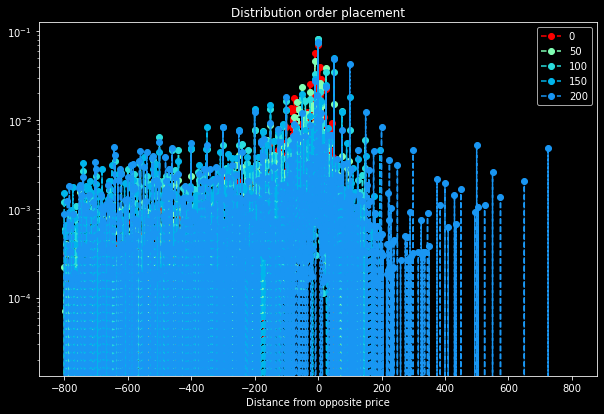

../main\MTY.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ret = N * np.log(s * (a +1) / ((1+ s)**(a +1) - 1))


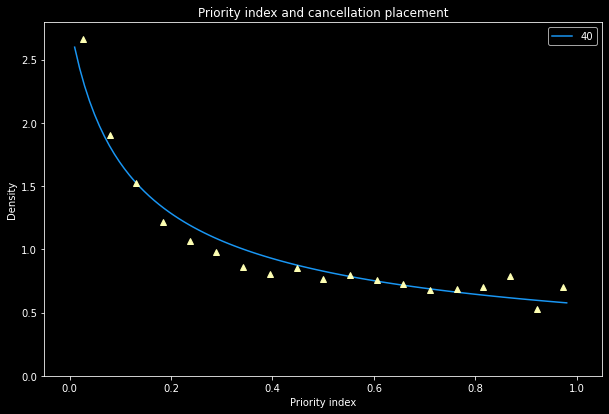

Spread simulations = 125.76,
Spread Empirical = 73.18
Volatility simulations = 15.19
Volatility Empirical = 11.33


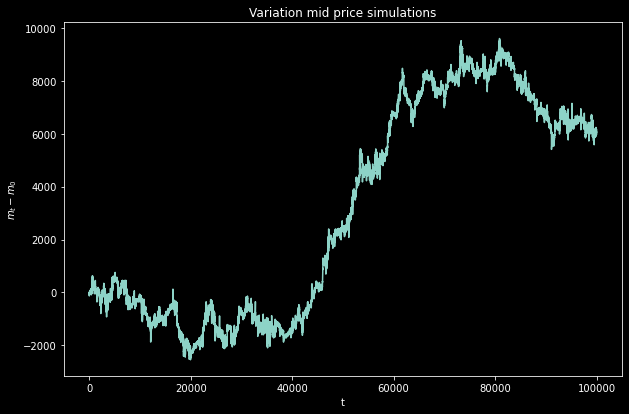

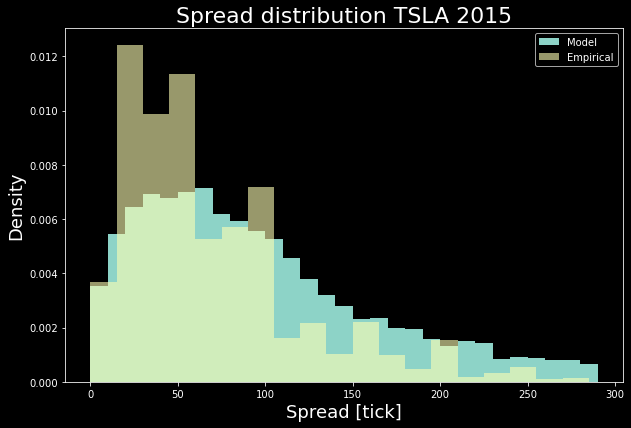

In [18]:
fig, ax = plt.subplots(1,1, figsize = (10,6.5))
spread = new_df["Spread"].mean()
volatility = ((new_df["MidPrice"].diff(1000)**2).mean() / 1000)**.5
lenght = int(spread * 20)
llob, sp, md, dd = MTY.sim_MTY_energy(ff1, ff2, ff3, lenght,
                                    100_000, f_distr, 50_000, alpha, sigma)
sim_spread= sp.mean()
sim_volatility = (((md[1000:] - md[:-1000])**2).mean()/1000)**0.5
print(f"Spread simulations = {sp.mean():.2f},\nSpread Empirical = {spread:.2f}")
print(f"Volatility simulations = {sim_volatility:.2f}")
print(f"Volatility Empirical = {volatility:.2f}")
ax.set_title("Variation mid price simulations")
ax.plot(md)
ax.set_ylabel(r"$m_t - m_0$")
ax.set_xlabel("t")
plt.show()